# Assignment 2

In [245]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

## check the data
- Is there existing missing values 
- How many missing values and valuable data

In [246]:
# There are existing invalid data in the dataset, so we need to remove them
test = pd.read_csv('./data/titanic.csv')
test = test[["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex", "Embarked", "Survived"]]
test_mean = test.mean()
test = test.fillna(test_mean)
rows_with_nan = test[test.isna().any(axis=1)]
rows_with_nan

,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,Survived
61,1,38.0,0,0,80.0,female,NaN,1
829,1,62.0,0,0,80.0,female,NaN,1


In [247]:
test = test.dropna()
len(test)

889

## Task 1 
1. Write a custom dataset class for the titanic data (see the data folder on GitHub).
2. Use only the features: "Pclass", "Age", "SibSp", "Parch", „Fare“, „Sex“, „Embarked“.
3. Preprocess the features accordingly in that class (scaling, one-hot-encoding, etc) and
4. split the data into train and validation data (80% and 20%). The constructor of that class
should look like this:
```
titanic_train = TitanicDataSet('titanic.csv', train=True)
titanic_val = TitanicDataSet('titanic.csv', train=False)
```

In [248]:
def TitanicDataSet(root_dir, train):
    minmax_scaler = MinMaxScaler()
    onehot_enc = OneHotEncoder()

    titanic = pd.read_csv(root_dir)
    # only need "Pclass", "Age", "SibSp", "Parch", „Fare“, „Sex“, „Embarked“
    titanic = titanic[["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex", "Embarked", "Survived"]]

    # because i found NaN in 'Age' column, so filled it with mean value
    # remove the NaN data in the dataset, which is from Embarked column, two rows
    mean_values = titanic.mean()
    titanic = titanic.fillna(mean_values)
    titanic = titanic.dropna()
    titanic = titanic.reset_index(drop=True) # reset the index, or combine_features will cause wrong index and length

    # devide the data into categorical features and numerical features, and put the 'Survived' column into categorical features
    categorical_features = titanic[titanic.select_dtypes(include=['object']).columns.tolist()]
    numerical_features = titanic[titanic.select_dtypes(exclude=['object']).columns].drop('Survived', axis=1)
    label_features = titanic['Survived']

    # use one-hot encoding to transform categorical features to numerical features
    numerical_features_arr = minmax_scaler.fit_transform(numerical_features)
    categorical_features_arr = onehot_enc.fit_transform(categorical_features).toarray()

    # combine the numerical features and categorical features
    combined_features = pd.DataFrame(data=numerical_features_arr, columns=numerical_features.columns)
    combined_features = pd.concat([combined_features, pd.DataFrame(data=categorical_features_arr)], axis=1)
    combined_features = pd.concat([combined_features, label_features], axis=1).reset_index(drop=True)


    # split the data into train and validation data (80% and 20%).
    if train:
        # return 80% of the data
        return combined_features.sample(frac=0.8, random_state=42)  # Use a random_state for reproducibility
    else: 
        # return 20% of the data
        return combined_features.sample(frac=0.2, random_state=42)  # Use the same random_state for consistency


In [249]:
titanic_train = TitanicDataSet('./data/titanic.csv', train=True)
titanic_val = TitanicDataSet('./data/titanic.csv', train=False)
print('train_dataset len:', len(titanic_train))
print('val_dataset len:', len(titanic_val))
print('total_dataset len:', len(titanic_train) + len(titanic_val))

train_dataset len: 711
val_dataset len: 178
total_dataset len: 889


In [250]:
titanic_train

,Pclass,Age,SibSp,Parch,Fare,0,1,2,3,4,Survived
280,1.0,0.346569,0.000,0.000000,0.015330,0.0,1.0,0.0,0.0,1.0,0
434,0.0,0.170646,0.125,0.333333,0.234224,1.0,0.0,0.0,0.0,1.0,1
39,1.0,0.170646,0.125,0.000000,0.021942,1.0,0.0,1.0,0.0,0.0,1
417,0.5,0.371701,0.000,0.000000,0.025374,0.0,1.0,0.0,0.0,1.0,0
584,0.0,0.220910,0.000,0.333333,0.155466,1.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
639,1.0,0.246042,0.000,0.000000,0.015330,0.0,1.0,0.0,0.0,1.0,0
876,1.0,0.367921,0.000,0.000000,0.015412,0.0,1.0,0.0,0.0,1.0,0
822,1.0,0.334004,0.000,0.166667,0.024350,1.0,0.0,0.0,0.0,1.0,1
801,0.0,0.132948,0.125,0.333333,0.234224,0.0,1.0,0.0,0.0,1.0,1


## Task 2 
Build a neural network with: 
1. [v] one hidden layer of size 3 that predicts the survival of the
passengers. 
2. [v] Use a BCE loss (Hint: you need a sigmoid activation in the output layer).
3. [v] Use a data loader to train in batches of size 16 and shuffle the data.

In [251]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        features = torch.FloatTensor(sample[:-1])  # Exclude the 'Survived' column
        label = torch.FloatTensor([sample['Survived']])  # 'Survived' column as label
        if self.transform:
            features = self.transform(features)
        return features, label

In [252]:
class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as member variables.
        """
        super(TwoLayerNet, self).__init__()
        # the weight and bias of linear1 will be initialized 
        # you can access them by self.linear1.weight and self.linear1.bias
        self.linear1 = nn.Linear(D_in, H) # this will create weight, bias for linear1
        self.linear2 = nn.Linear(H, D_out) # this will create weight, bias for linear2
        self.sigmoid = nn.Sigmoid() # Sigmoid activation for binary classification

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return a Tensor of output data.
        We can use Modules defined in the constructor as well as arbitrary operators on Tensors.
        """
        h_relu = F.relu(self.linear1(x))
        y_pred = self.sigmoid(self.linear2(h_relu))
        return y_pred

In [253]:
# N is batch size; 
# D_in is input dimension; 	10 features from Pclass/Age/SibSp/Parch/Fare/Sex[0	1]/Embarked[2	3	4]
# H is hidden dimension (Only one hidden layer, but containing 3 neurons.); 
# D_out is output dimension: 1 or 0 (Survived or not) 1 dimension for binary classification
N, D_in, H, D_out = 16, 10, 3, 1
lr = 0.001

network = TwoLayerNet(D_in, H, D_out)  # H=3 for one hidden layer with 3 neurons
optimizer = optim.Adam(network.parameters(), lr)  # RMSProp + Momentum 
criterion = nn.BCELoss() # Define the loss function as Binary Cross-Entropy Loss

n_epochs = 50 # You can adjust the number of epochs as needed
log_interval = 10 # Print the training status every log_interval epoch


In [254]:
train_losses = [] # Save the loss value of each training loop (epoch) of the neural network model during the training process
train_counter = [] # Save the number of images for training so far
test_losses = [] # Save the loss value of each test loop (epoch) of the neural network model during the training process
test_counter = [i*len(titanic_train) for i in range(n_epochs+1)] # how many data for training so far

In [255]:
train_dataset = CustomDataset(titanic_train)
train_dataloader = DataLoader(train_dataset, batch_size=N, shuffle=True)
test_dataset = CustomDataset(titanic_val)
test_dataloader = DataLoader(test_dataset, batch_size=N, shuffle=True)

In [256]:

def train(epoch):
    network.train()
    correct = 0
    cur_count = 0 

    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        # forward propagation
        output = network(data)
        loss = criterion(output, target)
                
        # Accuracy
        pred = (output >= 0.5).float()  # survival_rate is the threshold
        correct += (pred == target).sum().item()
        cur_count += len(data)

        # backword propagation
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy: {}/{} ({:.0f}%)'.format(
                epoch, 
                cur_count, 
                len(train_dataloader.dataset),
                100. * cur_count / len(train_dataloader.dataset), 
                loss.item(), 
                correct, len(train_dataloader.dataset),
                100. * correct / len(train_dataloader.dataset))
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*16) + ((epoch-1)*len(train_dataloader.dataset)))

In [257]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            # forward propagation
            output = network(data)
            test_loss += criterion(output, target).item()
            # Accuracy
            pred = (output >= 0.5).float()  # 0.5 is the threshold
            correct += (pred == target).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, 
        correct, 
        len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset))
    )

In [258]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Average loss: 0.0495, Accuracy: 68/178 (38%)

Train Epoch: 1 [16/711 (2%)]	Loss: 0.719072	 Accuracy: 6/711 (1%)
Train Epoch: 1 [176/711 (25%)]	Loss: 0.715786	 Accuracy: 71/711 (10%)
Train Epoch: 1 [336/711 (47%)]	Loss: 0.754785	 Accuracy: 126/711 (18%)
Train Epoch: 1 [496/711 (70%)]	Loss: 0.718186	 Accuracy: 178/711 (25%)


Train Epoch: 1 [656/711 (92%)]	Loss: 0.712994	 Accuracy: 244/711 (34%)

Test set: Average loss: 0.0476, Accuracy: 67/178 (38%)

Train Epoch: 2 [16/711 (2%)]	Loss: 0.713533	 Accuracy: 4/711 (1%)
Train Epoch: 2 [176/711 (25%)]	Loss: 0.702735	 Accuracy: 70/711 (10%)
Train Epoch: 2 [336/711 (47%)]	Loss: 0.696712	 Accuracy: 152/711 (21%)
Train Epoch: 2 [496/711 (70%)]	Loss: 0.663778	 Accuracy: 242/711 (34%)
Train Epoch: 2 [656/711 (92%)]	Loss: 0.703218	 Accuracy: 334/711 (47%)

Test set: Average loss: 0.0459, Accuracy: 110/178 (62%)

Train Epoch: 3 [16/711 (2%)]	Loss: 0.671103	 Accuracy: 11/711 (2%)
Train Epoch: 3 [176/711 (25%)]	Loss: 0.664172	 Accuracy: 112/711 (16%)
Train Epoch: 3 [336/711 (47%)]	Loss: 0.631486	 Accuracy: 207/711 (29%)
Train Epoch: 3 [496/711 (70%)]	Loss: 0.655020	 Accuracy: 310/711 (44%)
Train Epoch: 3 [656/711 (92%)]	Loss: 0.665396	 Accuracy: 398/711 (56%)

Test set: Average loss: 0.0440, Accuracy: 109/178 (61%)

Train Epoch: 4 [16/711 (2%)]	Loss: 0.615032	 Accuracy: 1

Text(0, 0.5, 'negative log likelihood loss (losses)')

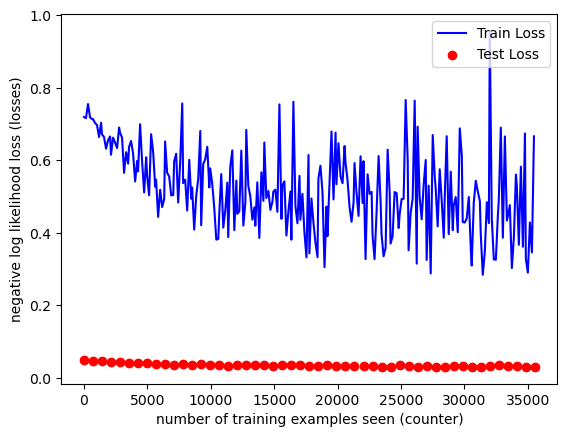

In [259]:
import matplotlib.pyplot as plt
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen (counter)')
plt.ylabel('negative log likelihood loss (losses)')